### Import Libraries

In [15]:
import pandas as pd
import random
import os
import numpy as np
import time
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
from hyperopt import fmin, hp, tpe
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as sm
from statsmodels.api import add_constant
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [17]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [18]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [19]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [20]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in df.columns:
        if df[col].var() == 0:
            result.append(col)
    return result

In [21]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [22]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [23]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [24]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [25]:
# 구글 드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# 데이터셋 설정
train_df = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/train.csv')
test_x = pd.read_csv('/content/drive/MyDrive/AI 프로젝트 자료/LG 자율주행 센서의 안테나 성능 예측/data/test.csv')

In [28]:
#train data 분리
train_x, train_y = dataset_split_X_y(train_df)
#train_x 에서 분산이 0인 data 추출
cols_with_zero_variance = zero_variance(train_x)
#train_x에서 분산이 0인 데이터 제거
train_x = train_x.drop(cols_with_zero_variance, axis = 1)
#test_x에서 분산이 0인 데이터 제거
test_x = test_x.drop(cols_with_zero_variance, axis = 1)

ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
      'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
      'Y_11', 'Y_12', 'Y_13', 'Y_14']
ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
             [7, 19], [22, 36.5], [-19.2, 19], 
             [2.4, 4], [-29.2, -24], [-29.2, -24],
             [-30.6, -20], [19.6, 26.6], [-29.2, -24],
             [-29.2, -24], [-29.2, -24]]

In [41]:
# Kolmogorov-Smirnov test(전체)
for i in train_x.columns:
    kolmogorov = stats.ks_2samp(train_x[i], test_x[i])
    print(i)
    print(kolmogorov)

X_01
KstestResult(statistic=0.003456738791692407, pvalue=0.9713084925230865)
X_02
KstestResult(statistic=0.0025794361993987103, pvalue=0.9993722964992025)
X_03
KstestResult(statistic=0.006506856164584185, pvalue=0.3698622397725747)
X_05
KstestResult(statistic=0.005542226945483675, pvalue=0.5751427109622602)
X_06
KstestResult(statistic=0.004704813333722524, pvalue=0.7711756205806983)
X_07
KstestResult(statistic=0.004024562662230335, pvalue=0.9041291609878521)
X_08
KstestResult(statistic=0.007277993613040823, pvalue=0.2437696626054271)
X_09
KstestResult(statistic=0.003951148350050893, pvalue=0.9153923750376989)
X_10
KstestResult(statistic=0.00027771657280095674, pvalue=1.0)
X_11
KstestResult(statistic=5.047955076020738e-05, pvalue=1.0)
X_12
KstestResult(statistic=0.004300690713242017, pvalue=0.8556951891813469)
X_13
KstestResult(statistic=0.00503301901901182, pvalue=0.695434336328649)
X_14
KstestResult(statistic=0.0052840099238602445, pvalue=0.635957212643392)
X_15
KstestResult(statistic

In [43]:
# Kolmogorov-Smirnov test(다른 분포)
for i in train_x.columns:
    kolmogorov = stats.ks_2samp(train_x[i], test_x[i])
    if kolmogorov[1] < 0.1: # pvalue = 10%보다 작은 것 도출(분포가 서로 다른 분포)
        print(i)
        print(kolmogorov)

X_21
KstestResult(statistic=0.009383307054219359, pvalue=0.060779088641920165)
X_53
KstestResult(statistic=0.009155979514484214, pvalue=0.07183064091782532)


In [46]:
train_x['X_21'].describe()

count    39607.000000
mean         3.174270
std          0.106868
min          2.830000
25%          3.090000
50%          3.160000
75%          3.250000
max          3.680000
Name: X_21, dtype: float64

In [45]:
test_x['X_21'].describe()

count    39608.000000
mean         3.172318
std          0.106410
min          2.840000
25%          3.090000
50%          3.150000
75%          3.240000
max          3.610000
Name: X_21, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


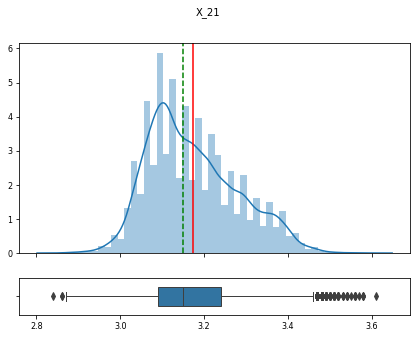

In [47]:
adjacent_histogram_boxplot(test_x['X_21'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


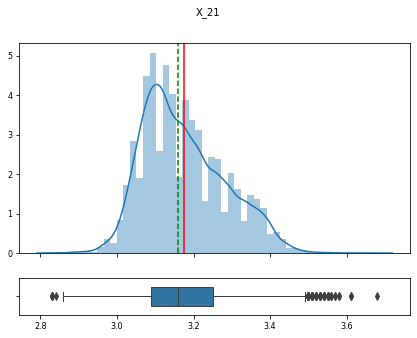

In [61]:
adjacent_histogram_boxplot(train_x['X_21'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


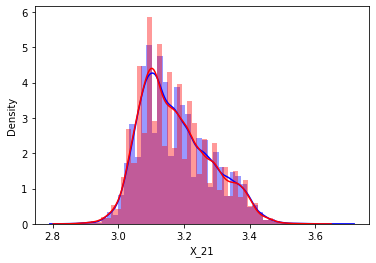

In [64]:
sns.distplot(train_x['X_21'], color = 'blue')
sns.distplot(test_x['X_21'], color = 'red')
plt.show()

In [53]:
train_x['X_53'].describe()

count    39607.000000
mean       127.992420
std          5.713153
min         21.330000
25%        124.374525
50%        128.020010
75%        131.618662
max        152.406630
Name: X_53, dtype: float64

In [54]:
test_x['X_53'].describe()

count    39608.000000
mean       128.012468
std          6.022616
min         21.330000
25%        124.397173
50%        128.048022
75%        131.706046
max        169.774016
Name: X_53, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


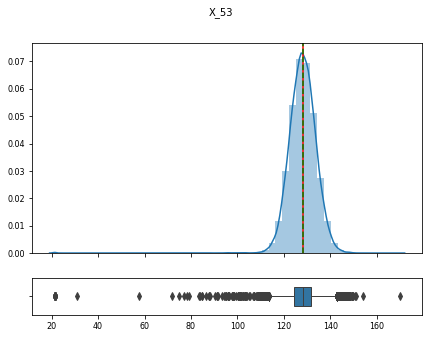

In [55]:
adjacent_histogram_boxplot(test_x['X_53'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


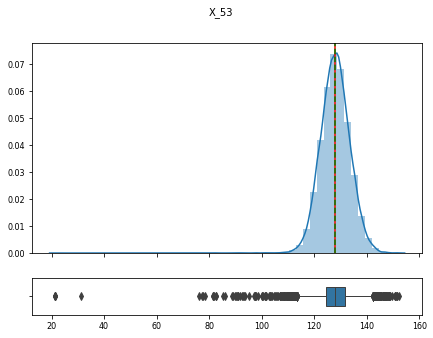

In [57]:
adjacent_histogram_boxplot(train_x['X_53'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


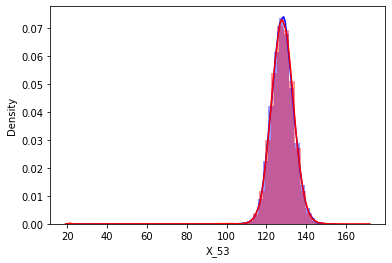

In [65]:
sns.distplot(train_x['X_53'], color = 'blue')
sns.distplot(test_x['X_53'], color = 'red')
plt.show()